# Project Statement

The Film Junky Union, is a new edgy community for classic movie enthusiasts, it's developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. We'll be using a dataset from IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import re
import nltk
import spacy

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# The next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')


In [3]:
# This is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()


## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})


In [5]:
df_reviews.head()


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.duplicated().sum()


0

In [7]:
df_reviews.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [8]:
df_reviews.describe()


,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [9]:
df_reviews.isna().sum()


tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [10]:
df_reviews.isna().sum()/len(df_reviews)*100


tconst             0.000000
title_type         0.000000
primary_title      0.000000
original_title     0.000000
start_year         0.000000
end_year           0.000000
runtime_minutes    0.000000
is_adult           0.000000
genres             0.000000
average_rating     0.004226
votes              0.004226
review             0.000000
rating             0.000000
sp                 0.000000
pos                0.000000
ds_part            0.000000
idx                0.000000
dtype: float64

In [11]:
df_reviews[df_reviews["average_rating"].isna()]


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [12]:
# There are two rows with missing values, we will fill them so the model won't get stuck
df_reviews['average_rating'] = df_reviews['average_rating'].fillna(6.0)
df_reviews['votes'] = df_reviews['votes'].fillna(df_reviews['votes'].min())


/tmp/ipykernel_388/1671935889.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_reviews.hist(ax = ax)


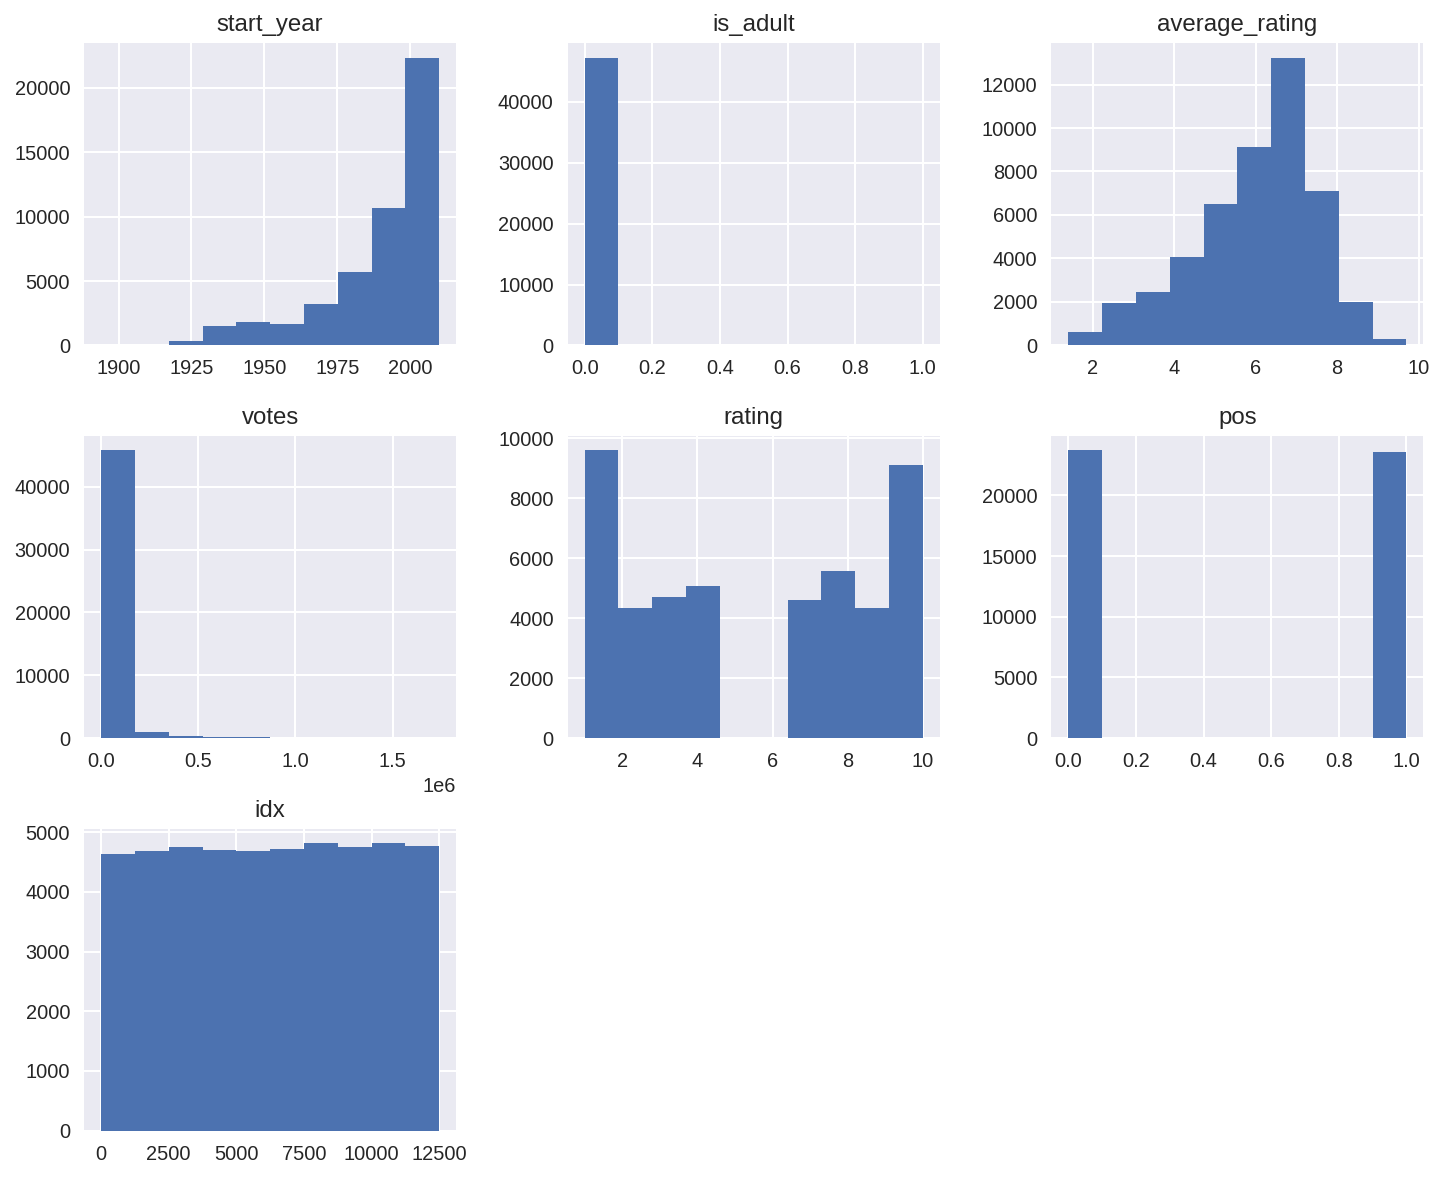

In [13]:
fig = plt.figure(figsize = (12,10))
ax = fig.gca()
df_reviews.hist(ax = ax)
fig = ax.get_figure()


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pos', ylabel='count'>

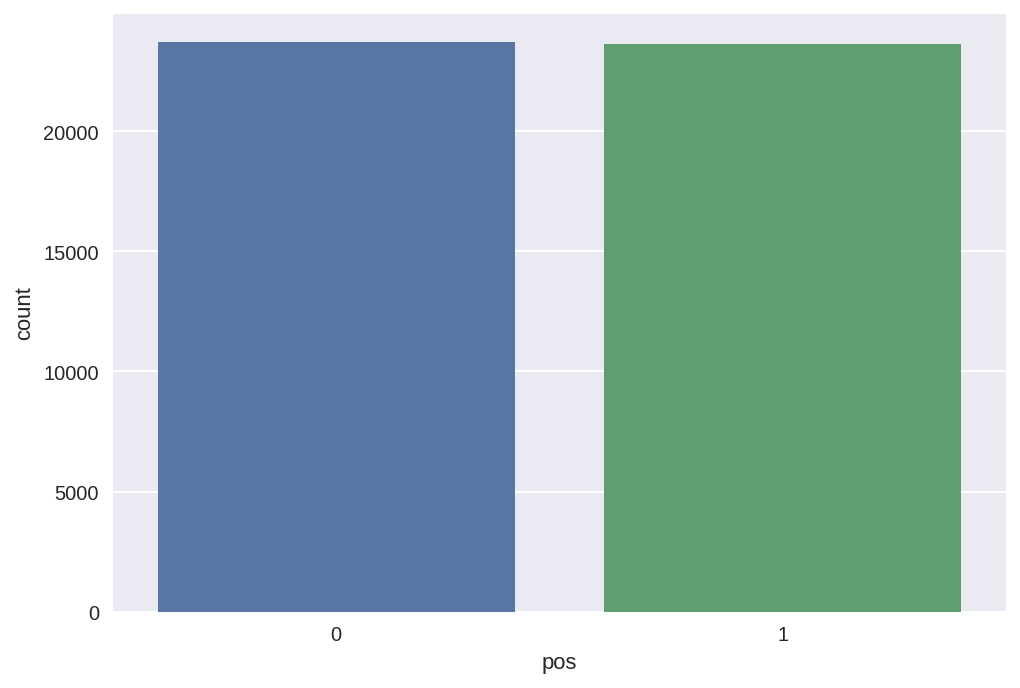

In [14]:
sns.countplot(df_reviews["pos"])


In [15]:
df_reviews['pos'].value_counts()


0    23715
1    23616
Name: pos, dtype: int64

## EDA

Let's check the number of movies and reviews over years.

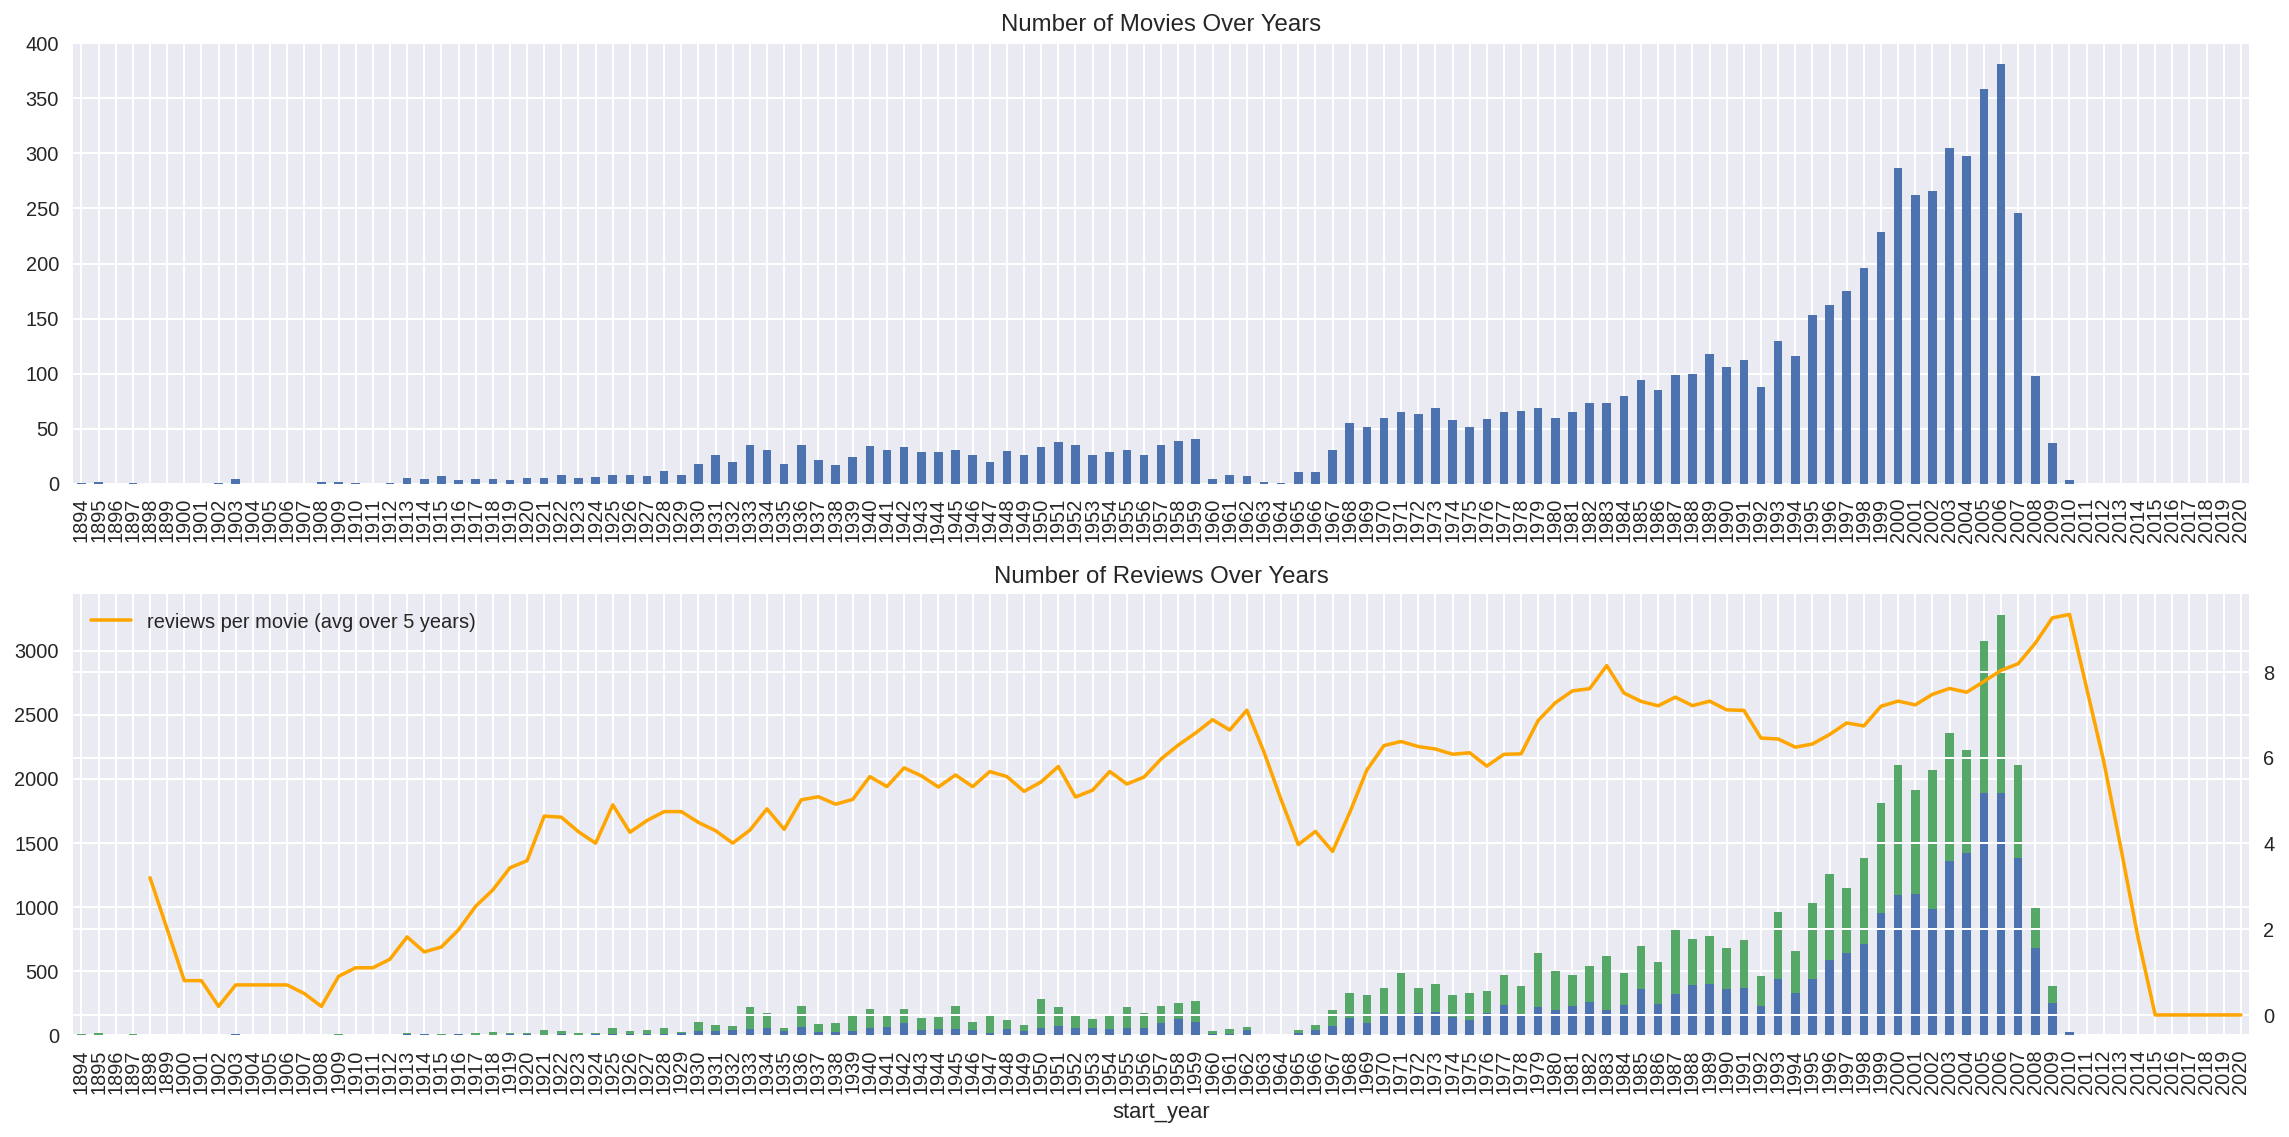

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

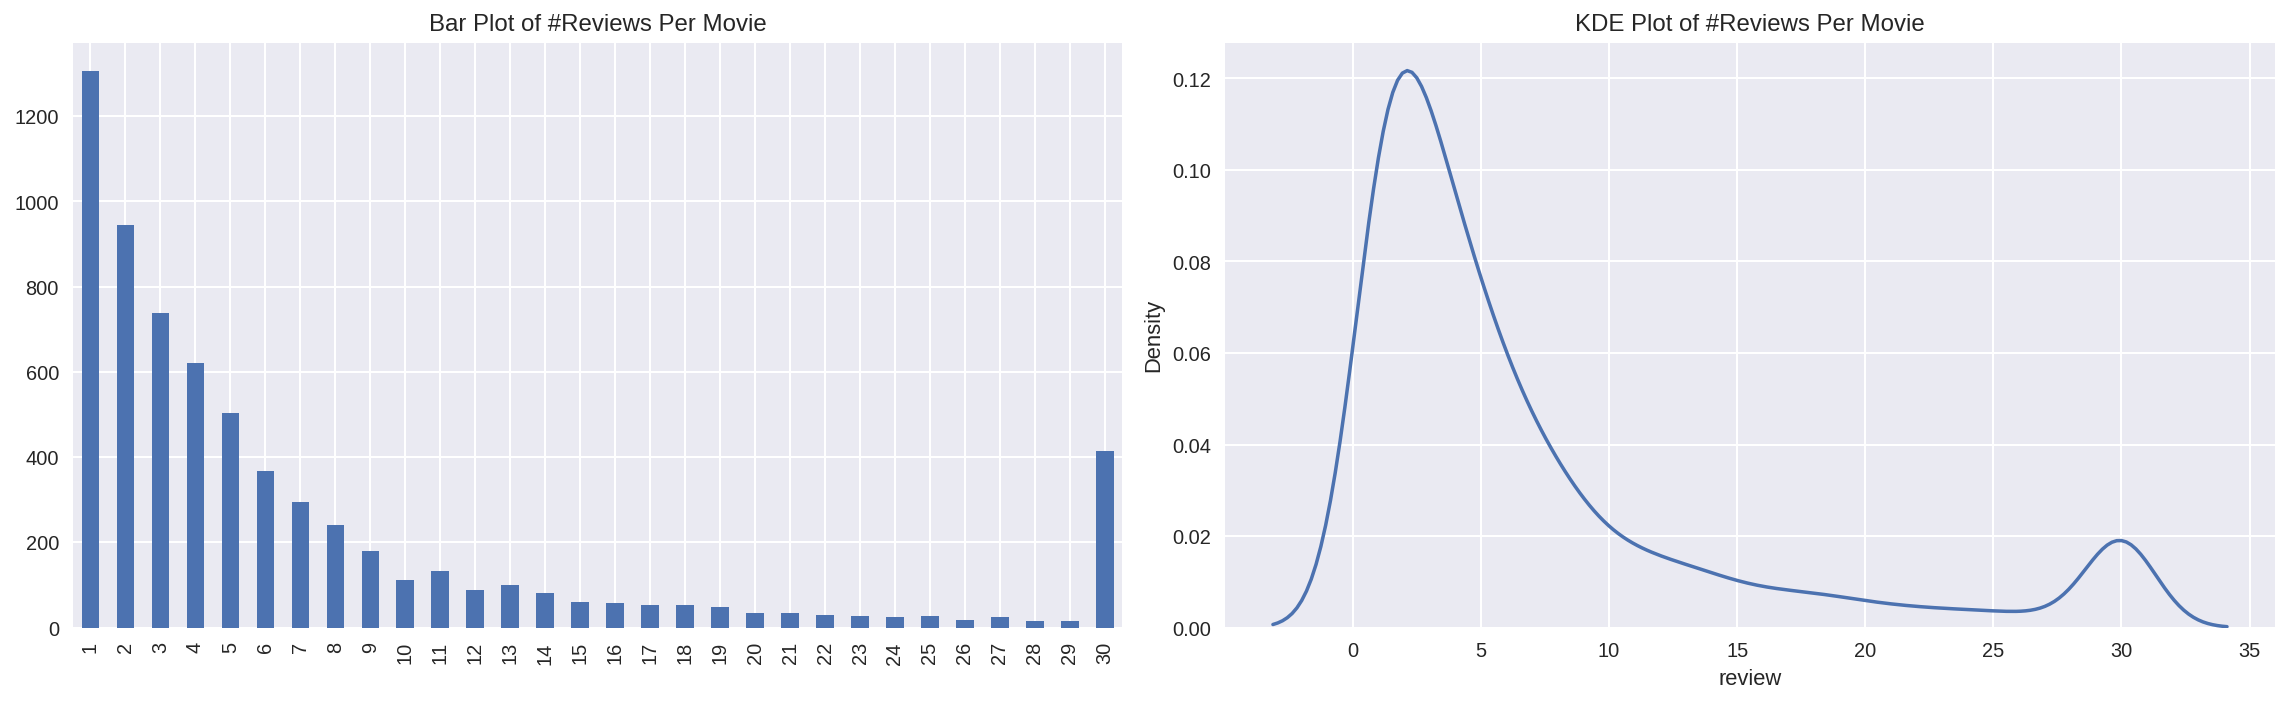

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [18]:
df_reviews['pos'].value_counts()


0    23715
1    23616
Name: pos, dtype: int64

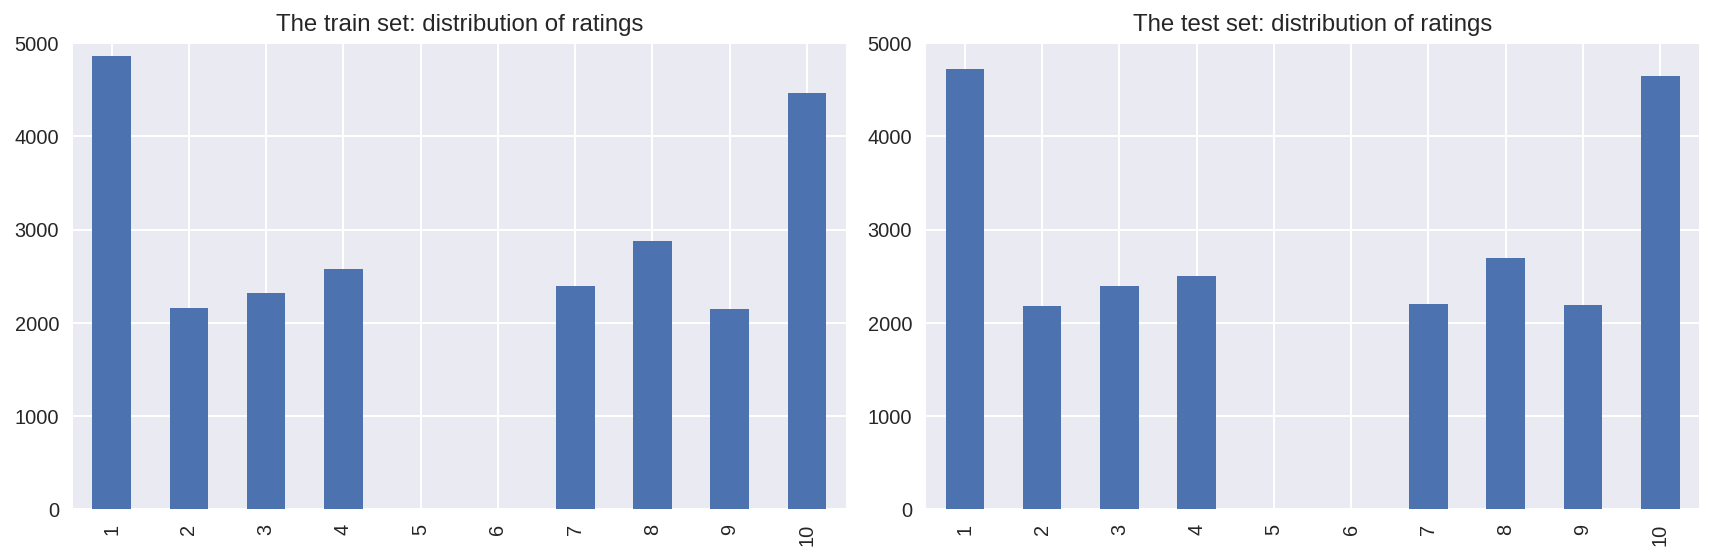

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()


Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


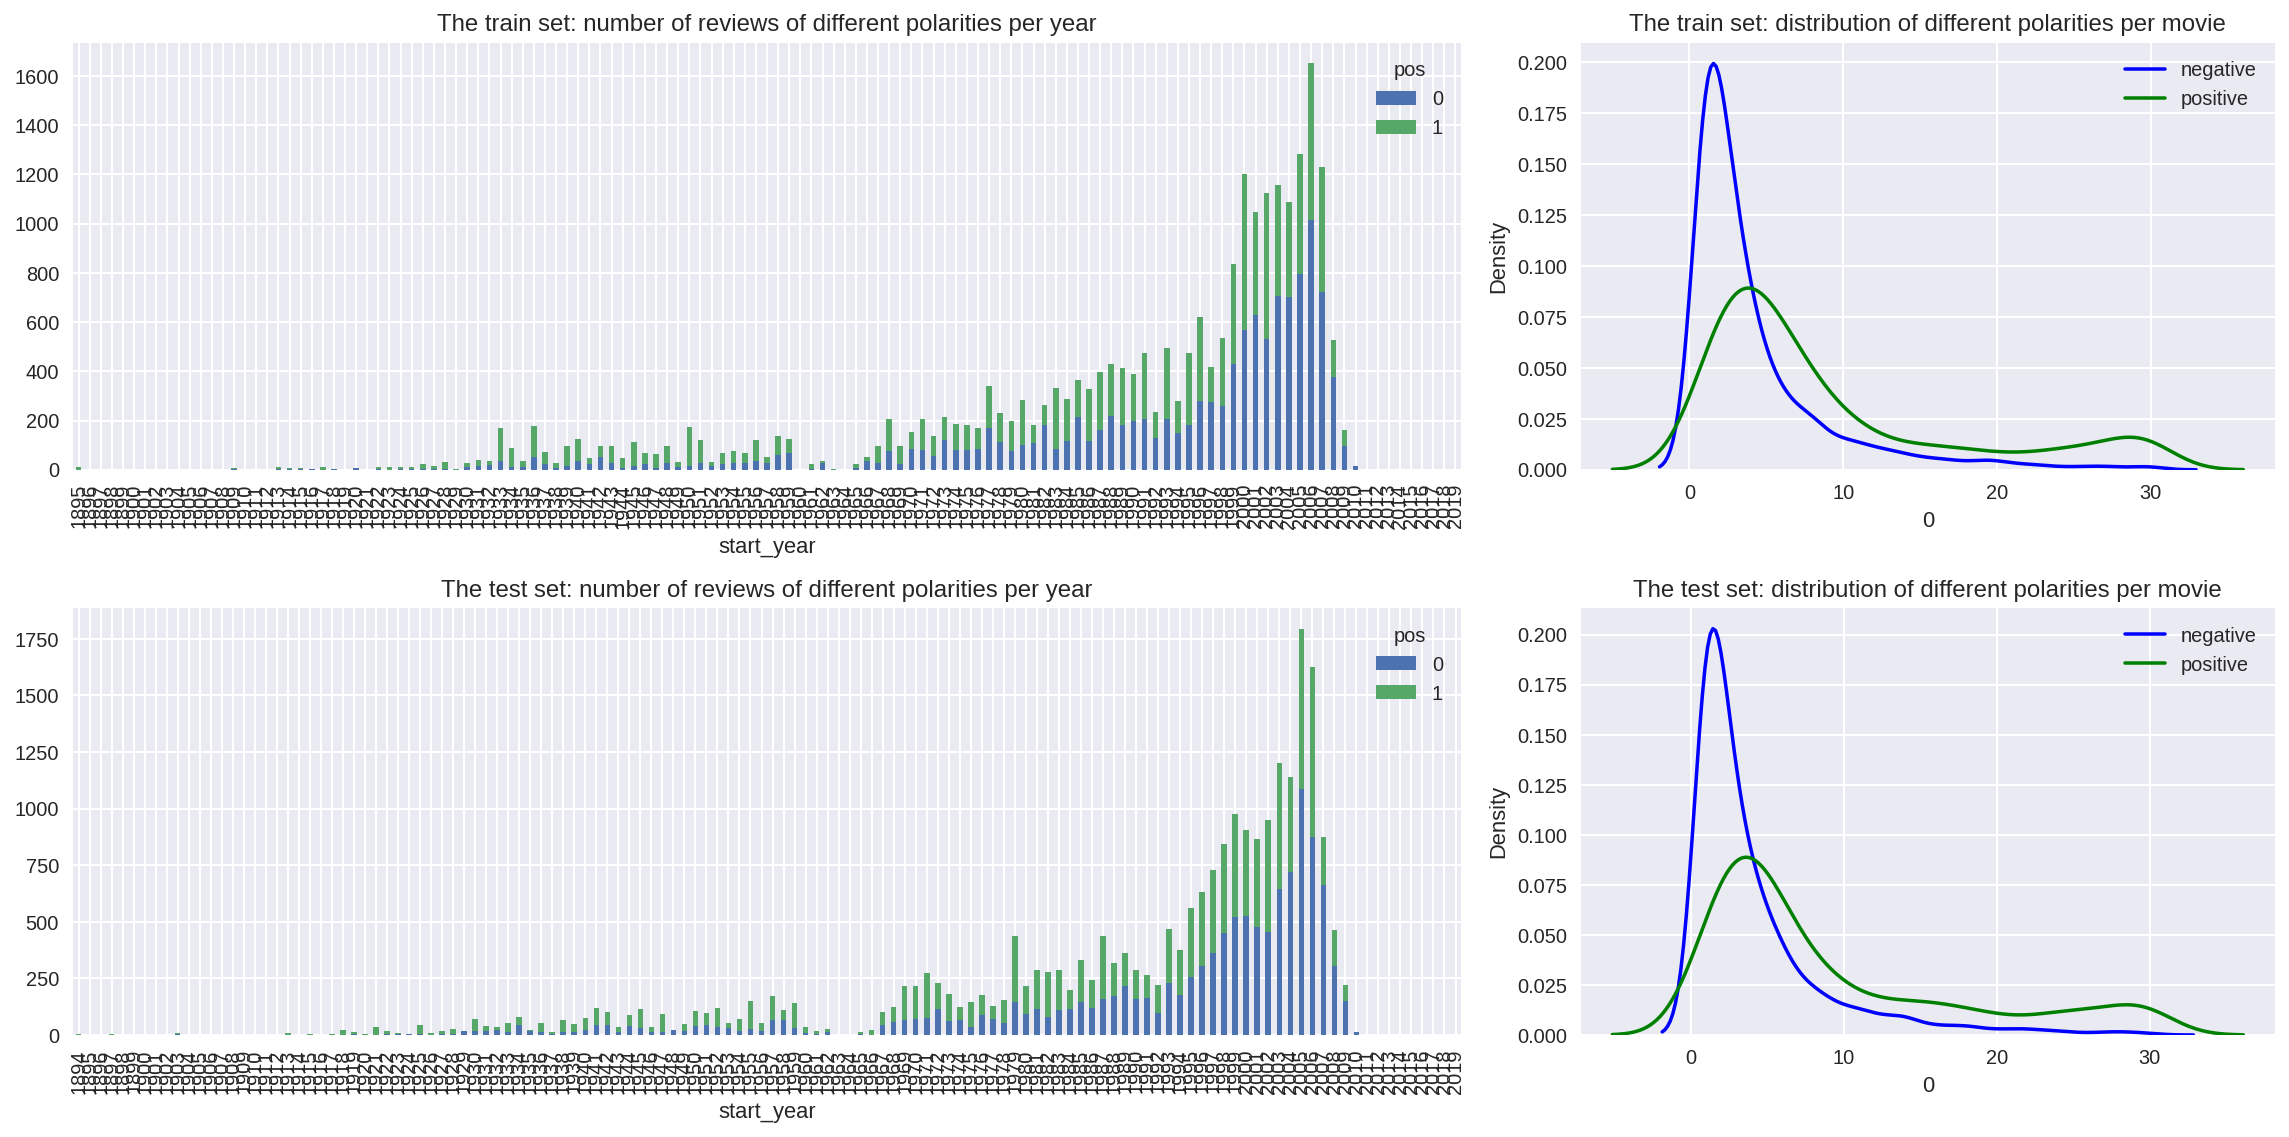

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [21]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [22]:
import spacy

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer


In [23]:
nltk.download(['stopwords', 'punkt', 'wordnet'])


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
stop_words = set(nltk_stopwords.words('english'))


In [25]:
nltk_lemmatizer = WordNetLemmatizer()


In [26]:
spacy.prefer_gpu()
spacy_nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


In [27]:
def lemmatize(corpus, method='spacy'):
    
    def nltk_lem(string):
        return ' '.join([nltk_lemmatizer.lemmatize(token) for token in word_tokenize(string)] )
    
    
    def spacy_lem(string):
        return ' '.join([token.lemma_ for token in spacy_nlp(string)])
        
        
    if method == 'nltk':
        return corpus.apply(nltk_lem)
    elif method == 'spacy':
        return corpus.apply(spacy_lem)
    else:
        return corpus
    

In [28]:
df_reviews['review_norm'] = df_reviews['review'].str.replace(r"[^a-zA-Z']", ' ', regex=True).str.lower()


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one part. The corresponding flag is 'ds_part'.

In [29]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


In [30]:
X_train = df_reviews_train['review_norm']
y_train = train_target


In [31]:
X_test = df_reviews_test['review_norm']
y_test = test_target


## Working with models

In [32]:
random_state = 42

### Model 0 - Constant

In [33]:
from sklearn.pipeline import make_pipeline

def create_pipeline(model):
    return make_pipeline(
        TfidfVectorizer(stop_words=stop_words),
        model)


In [34]:
from sklearn.dummy import DummyClassifier


stratified
          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5

most_frequent
          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5

prior
          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5

uniform
          train  test
Accuracy   0.51   0.5
F1         0.51   0.5
APS        0.50   0.5
ROC AUC    0.50   0.5



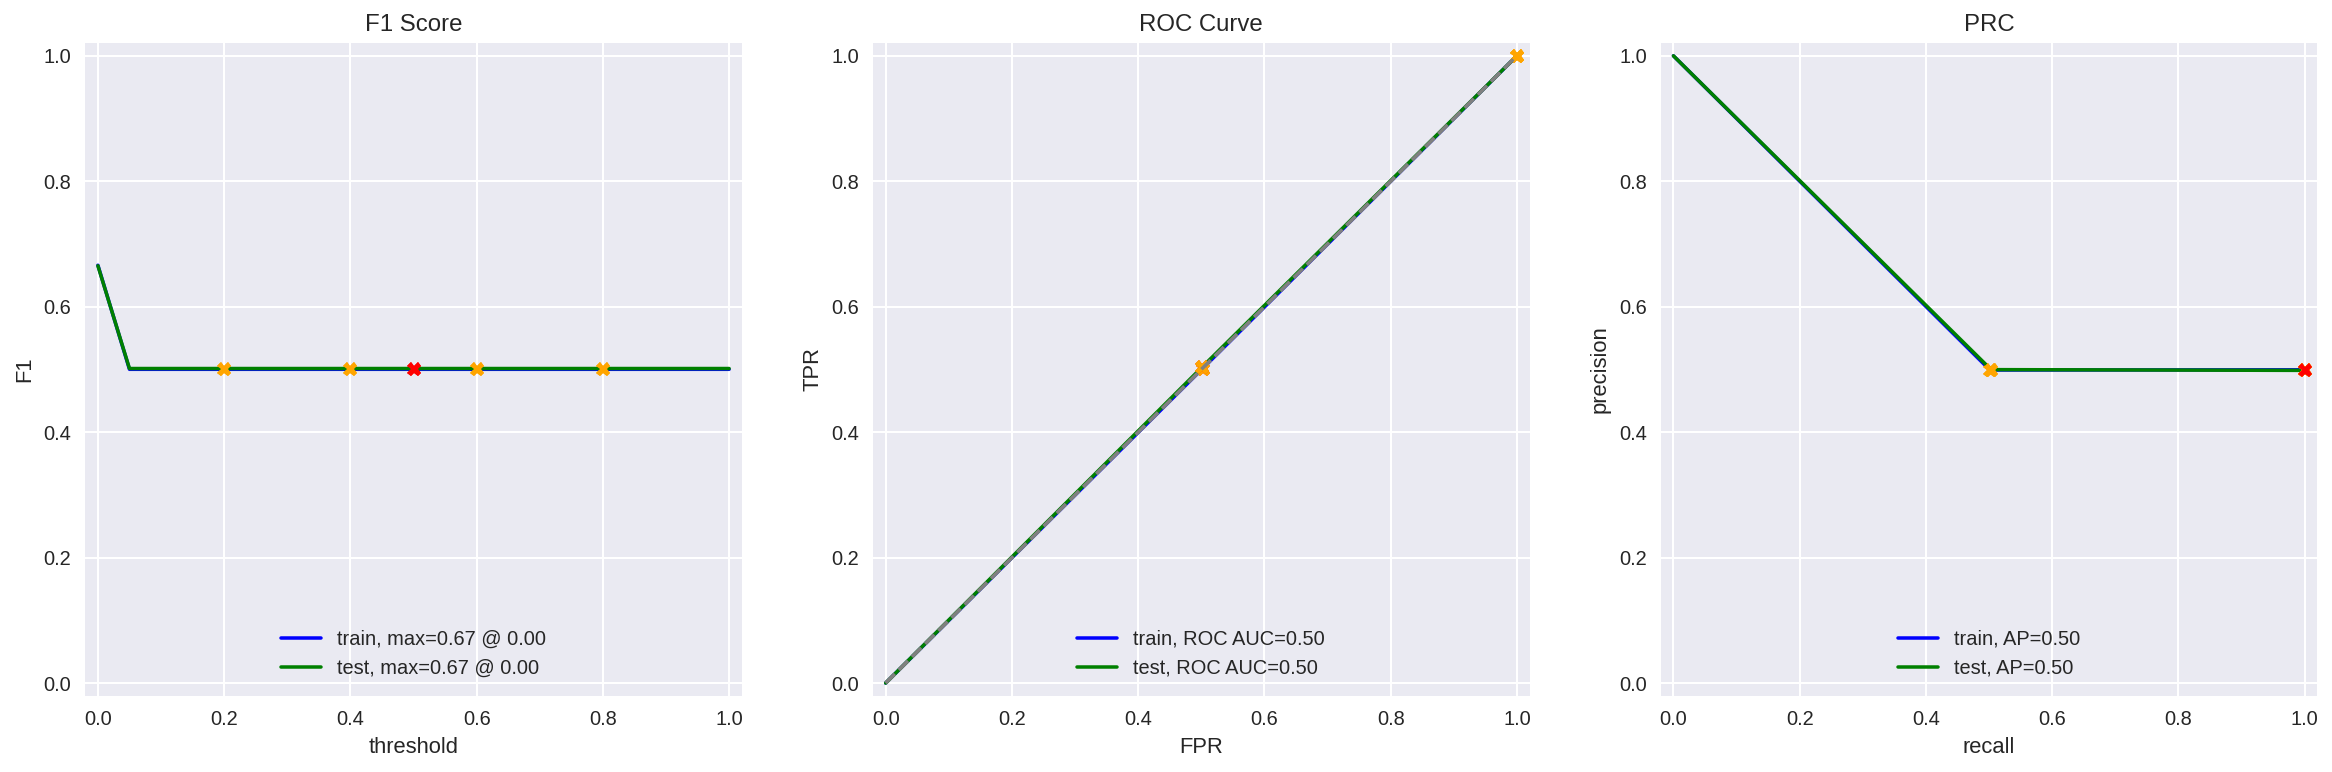

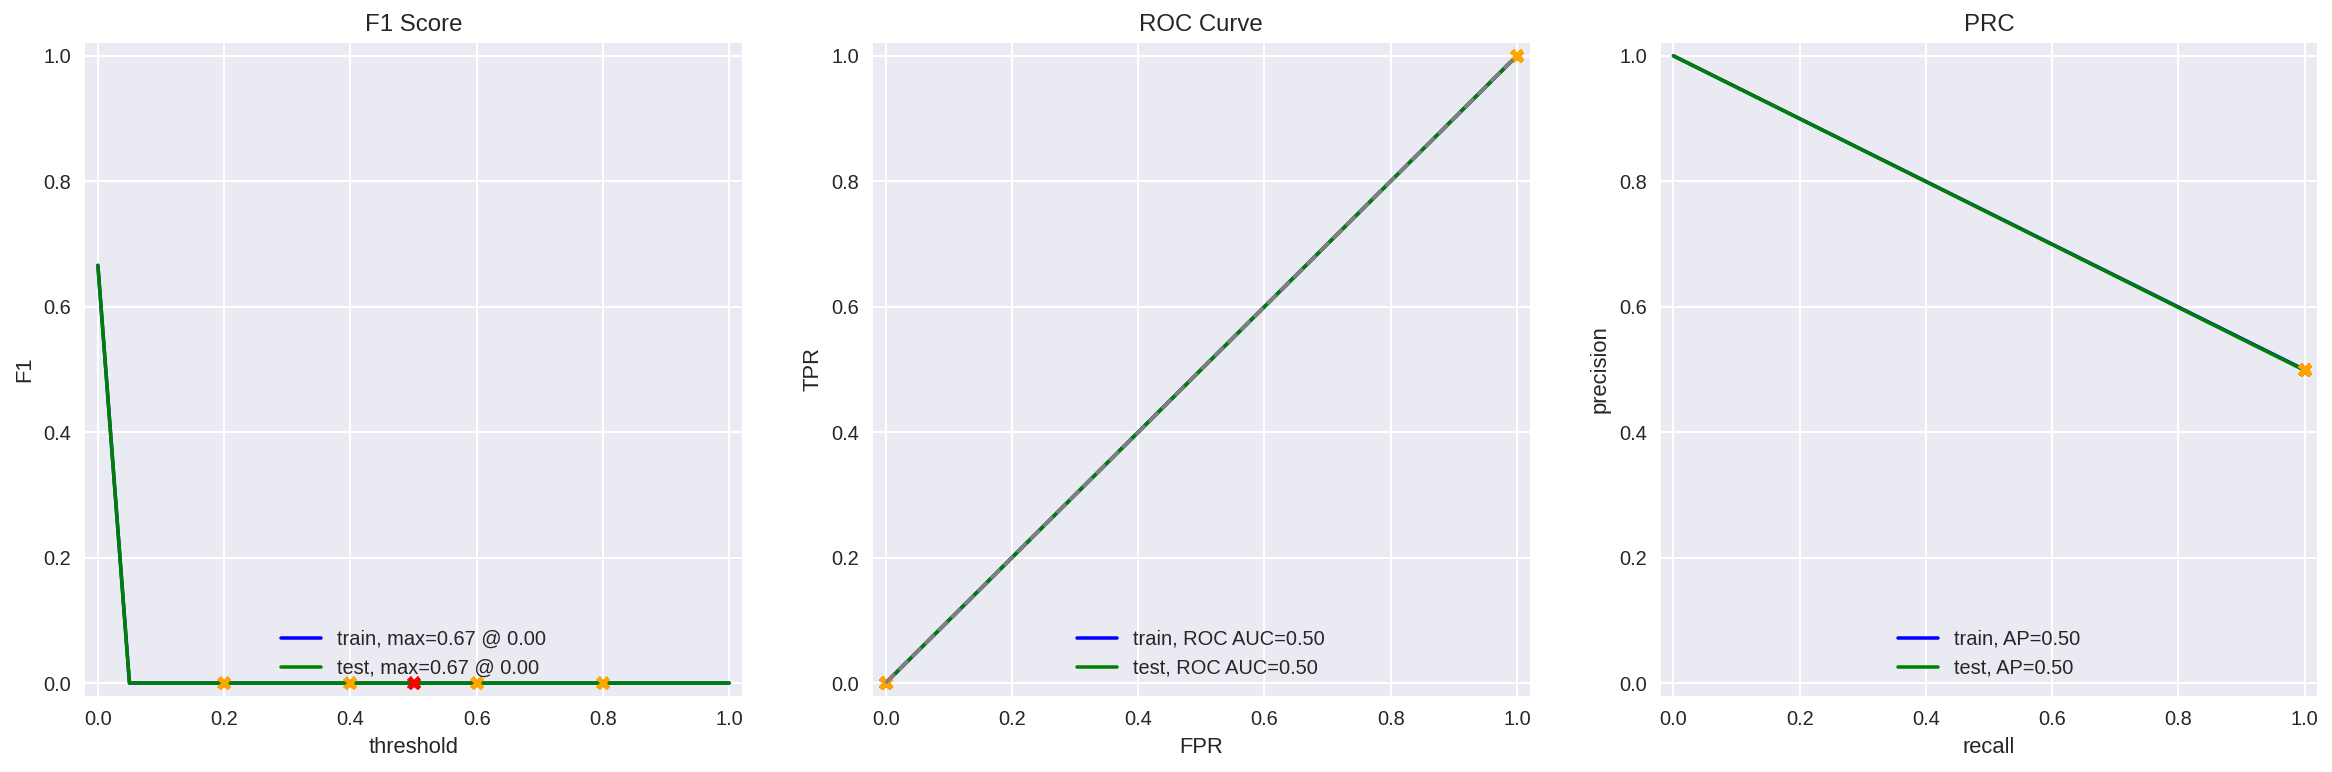

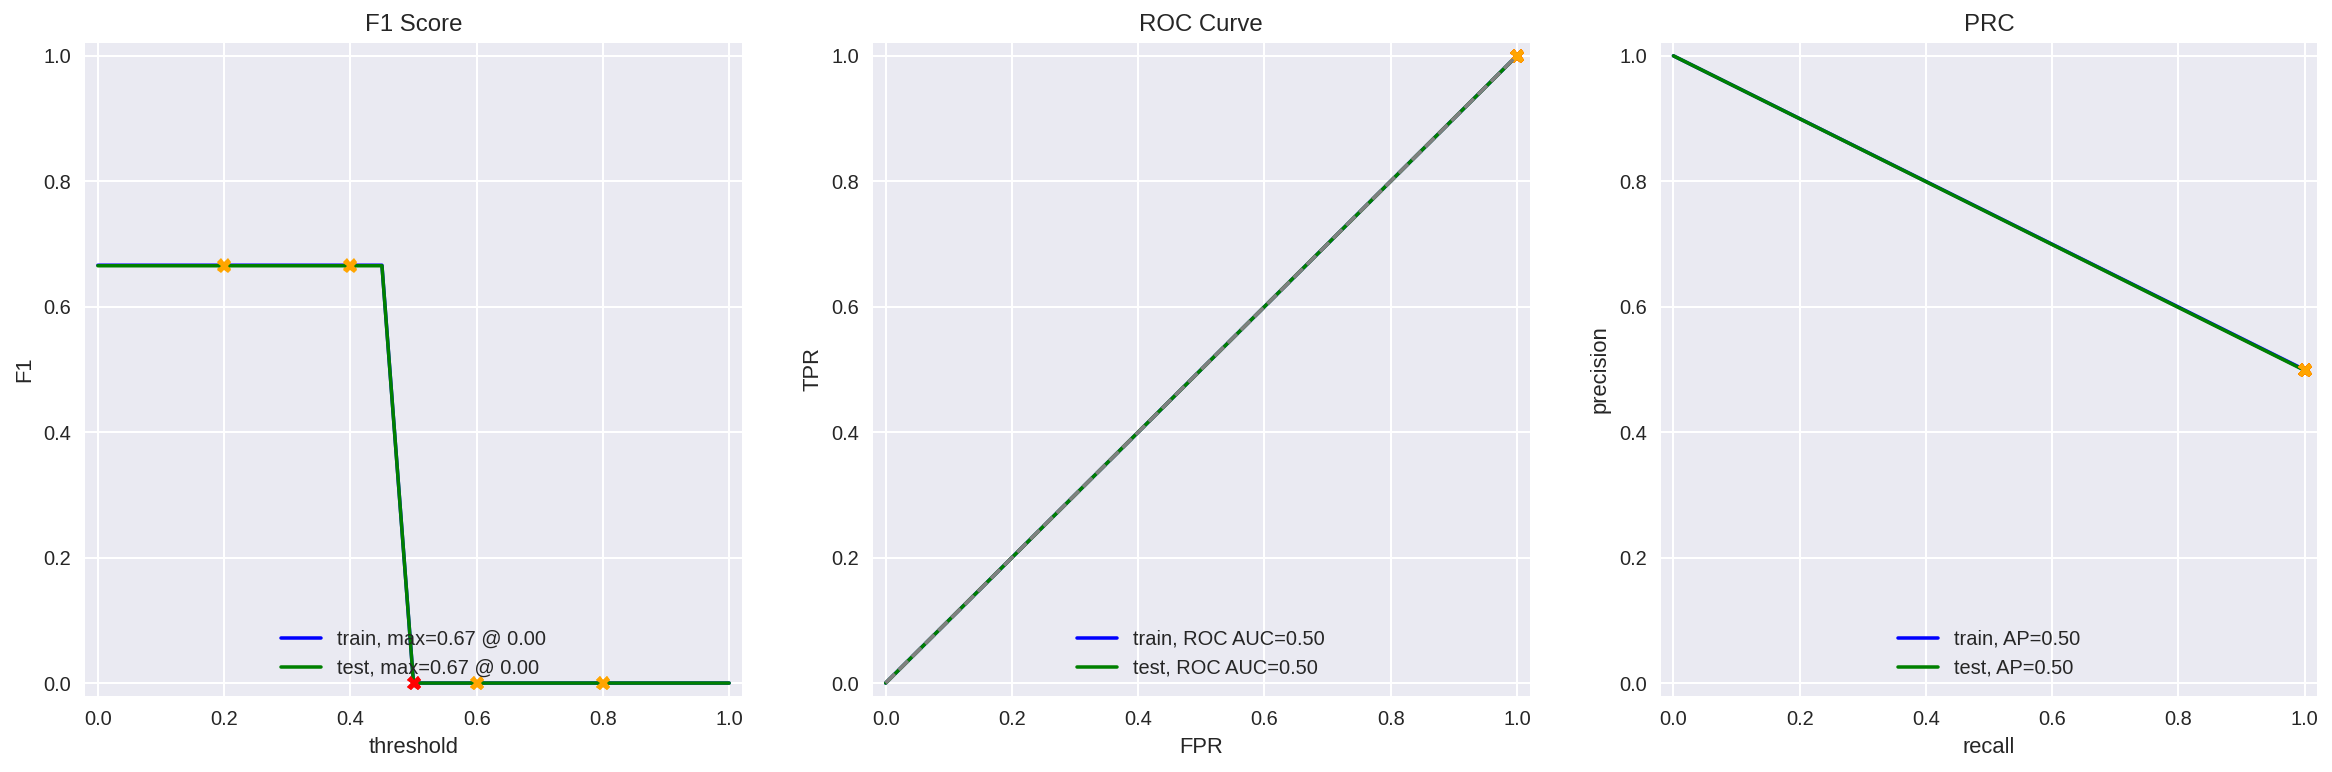

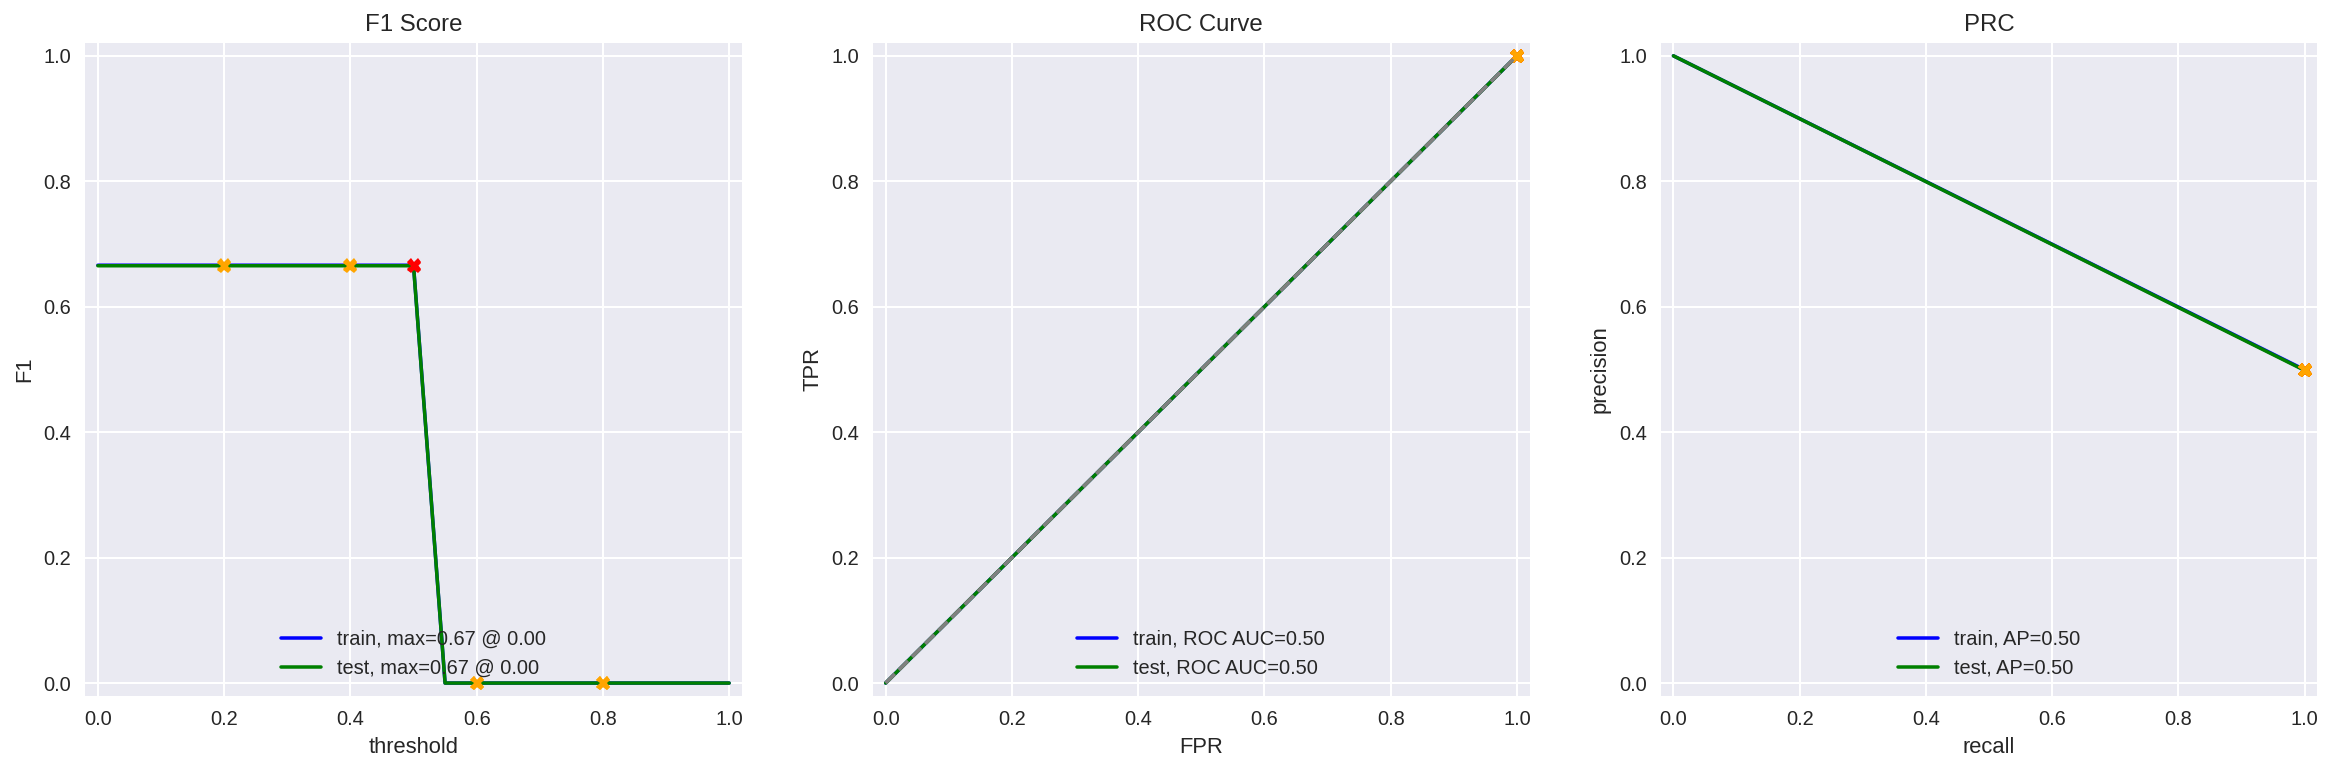

In [35]:
for strategy in ["stratified", "most_frequent", "prior", "uniform"]:
    print(strategy)
    dummy = create_pipeline(DummyClassifier(strategy=strategy, random_state=random_state))
    dummy.fit(X_train, y_train)
    evaluate_model(dummy, X_train, y_train, X_test, y_test)
    print()

### Model 1 - NLTK, TF-IDF and LR

In [36]:
from sklearn.linear_model import LogisticRegression


In [37]:
train_features_1 = lemmatize(X_train, 'nltk')


In [38]:
test_features_1 = lemmatize(X_test, 'nltk')


In [39]:
model_1 = create_pipeline(LogisticRegression(random_state=random_state))


In [40]:
model_1.fit(train_features_1, train_target);


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


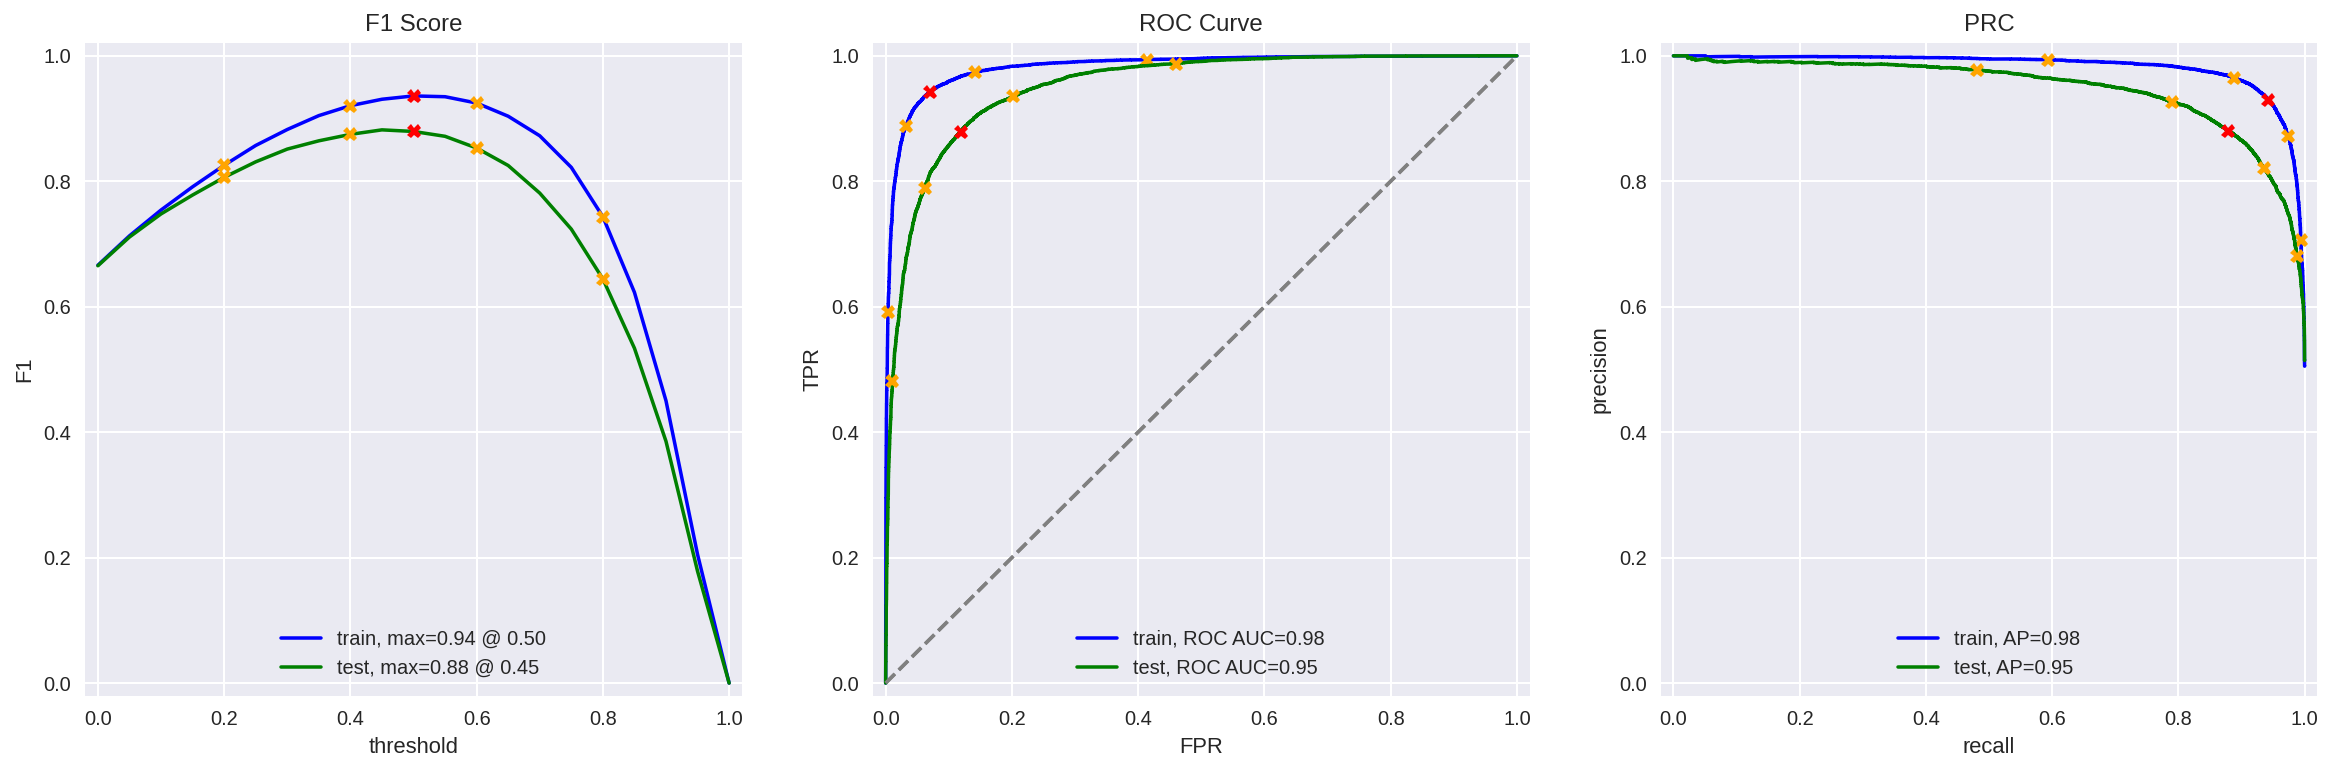

In [41]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)


### Model 3 - spaCy, TF-IDF and LR

In [42]:
train_features_3 = lemmatize(X_train, 'spacy')


In [43]:
test_features_3 = lemmatize(X_test, 'spacy')


In [44]:
model_3 = create_pipeline(LogisticRegression(random_state=random_state))


In [45]:
model_3.fit(train_features_3, train_target);


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


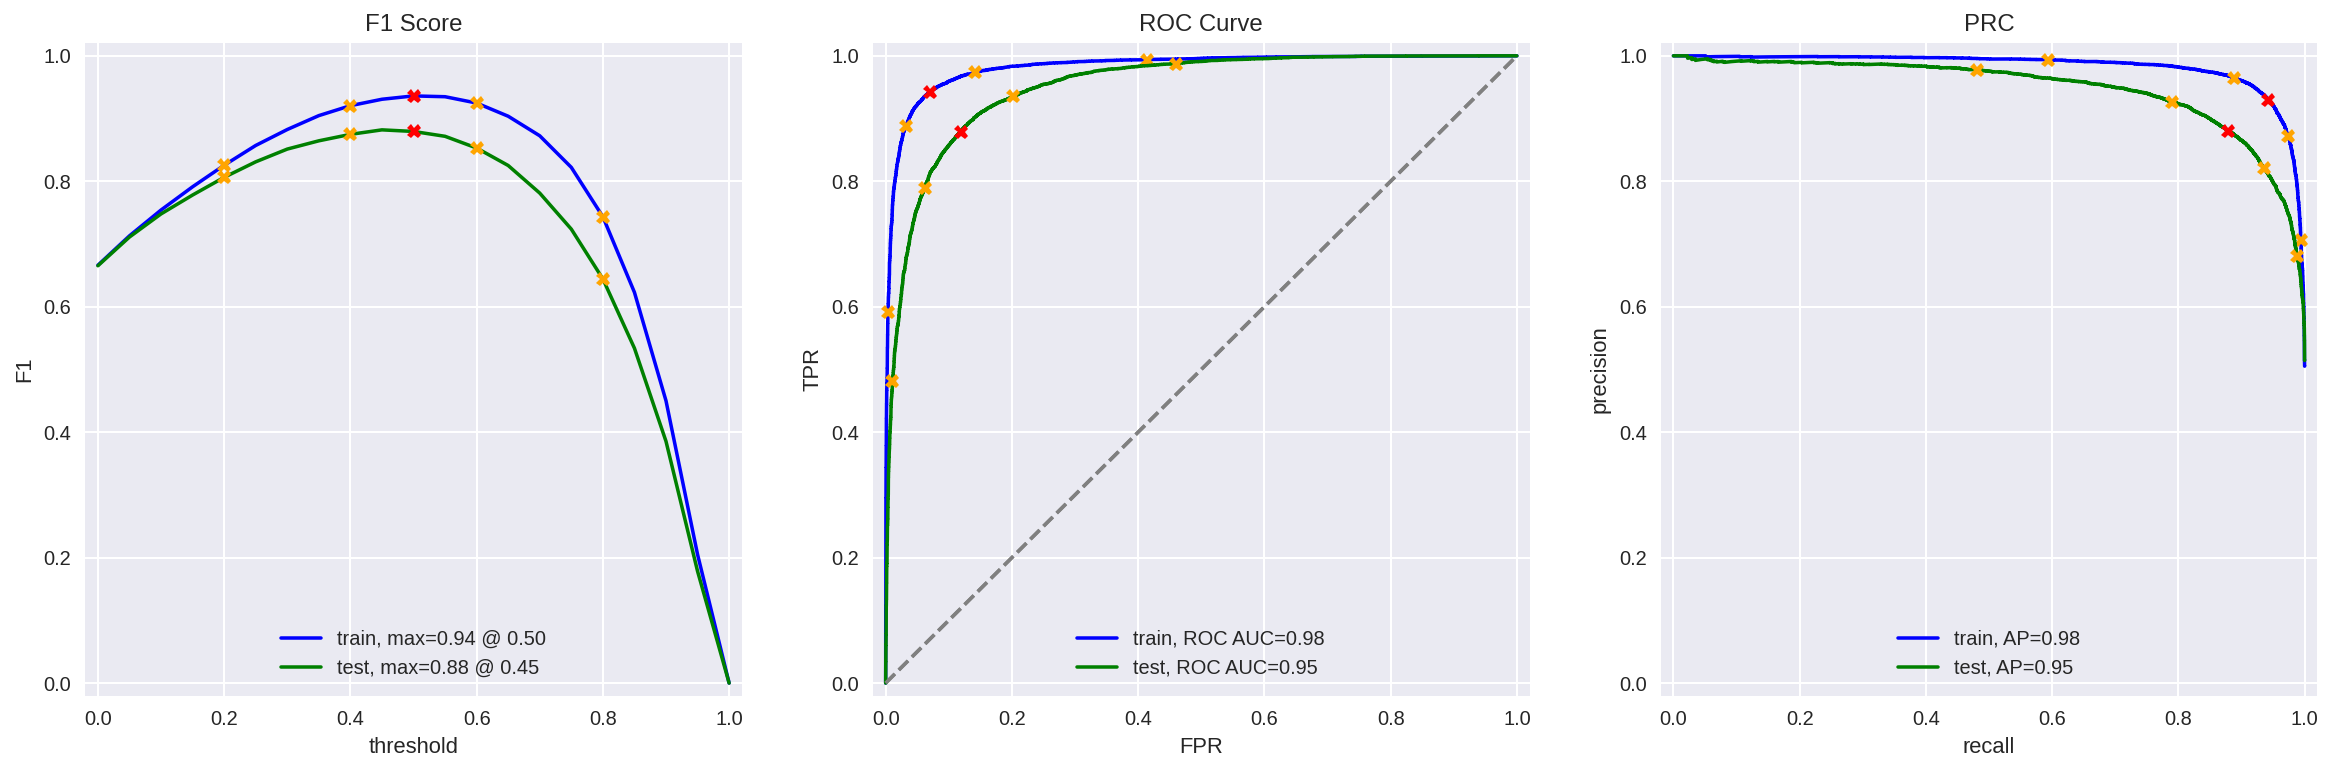

In [46]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)


### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [47]:
from lightgbm import LGBMClassifier


In [48]:
model_4 = create_pipeline(LGBMClassifier(random_state=random_state))


In [49]:
model_4.fit(train_features_3, train_target);


          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


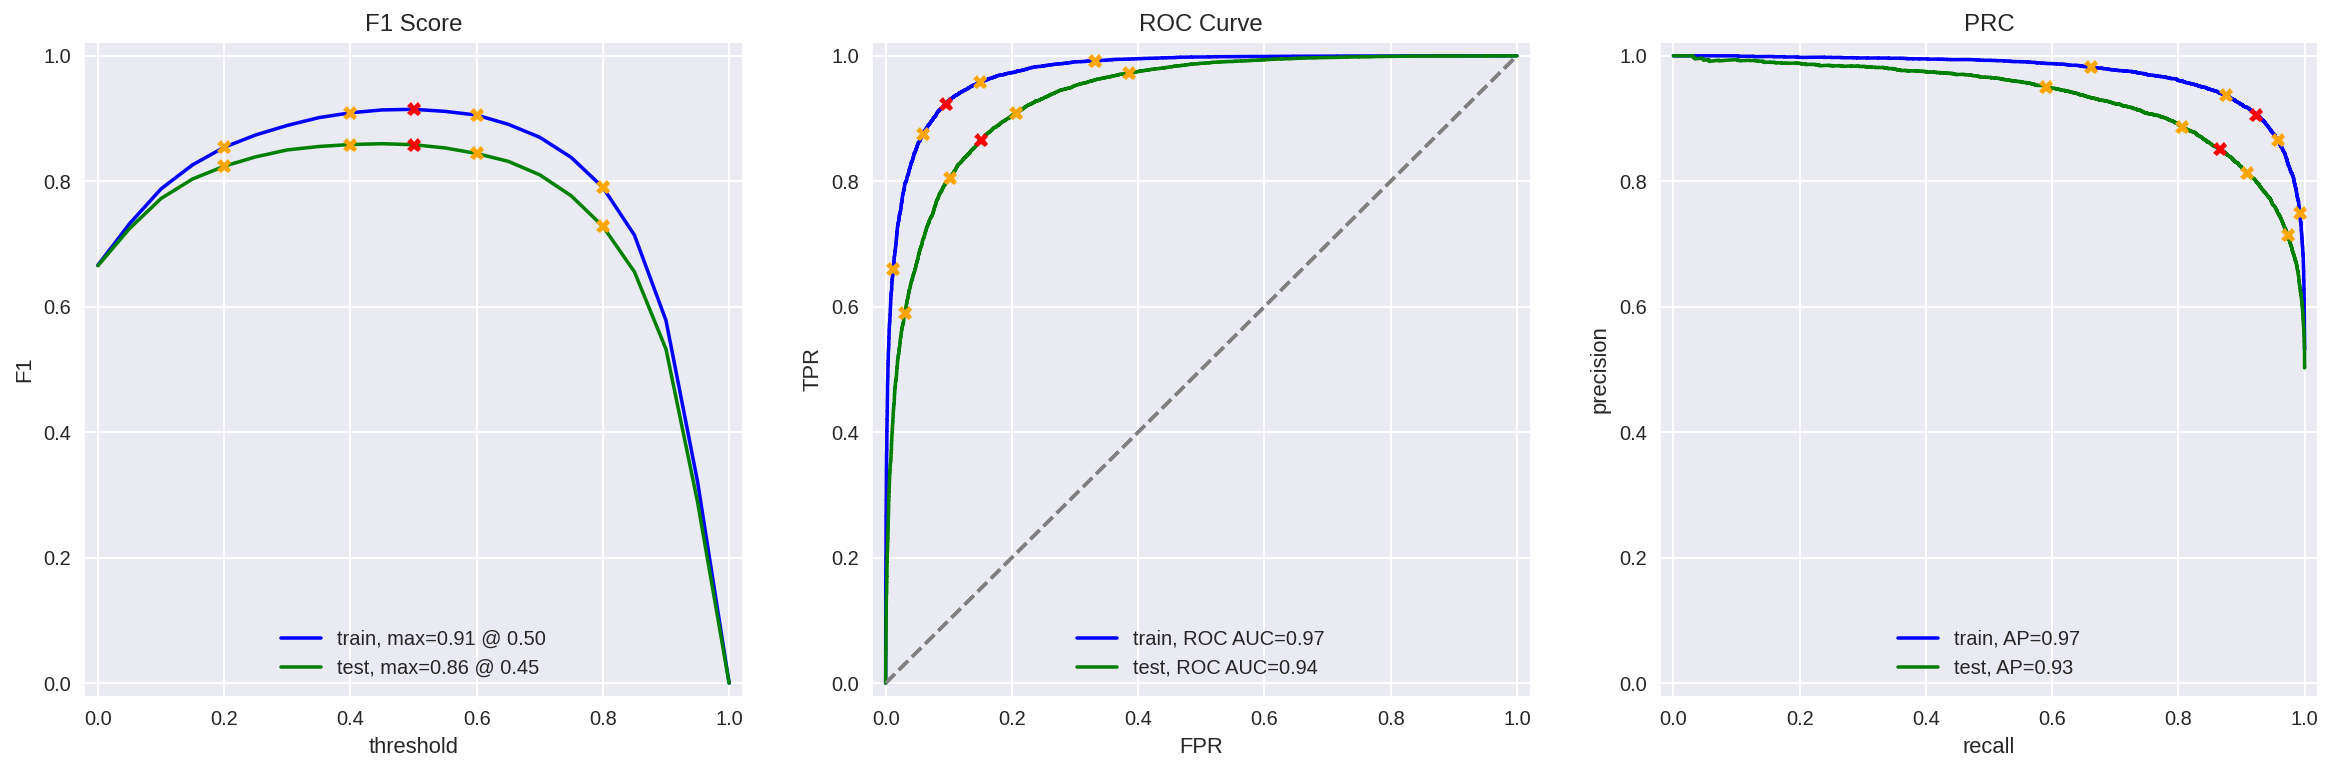

In [50]:
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)


## My Reviews

In [51]:
# Feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.',
    'Amazing show!!',
    'What a crappy show!',
    'Wasted my time',
    'Best show ever!',
    'The series started a little slow, but quickly picked up in the later episodes\!',
    'Couldn\'t stop laughing the whole time. Wish it was longer\!',
    'I am Batman\!',
    'Good for having in the background when doing other things',
    'Wtf happened to Mickey Rourke\??',
    'Glad I found this series before i started my homework',
    'Could this show \'be any more awesome\'\??',
    'I wish my eyes could unsee this filth'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].str.replace(r"[^a-zA-Z']", ' ', regex=True).str.lower()

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middl...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good writ...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a singl...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i real...
8,Amazing show!!,amazing show
9,What a crappy show!,what a crappy show


### Model 2

In [52]:
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_1.predict_proba(texts)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')
    

0.16:  i did not simply like it  not my kind of movie 
0.18:  well  i was bored and felt asleep in the middle of the movie 
0.58:  i was really fascinated with the movie
0.17:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.39:  i didn't expect the reboot to be so good  writers really cared about the source material
0.49:  the movie had its upsides and downsides  but i feel like overall it's a decent flick  i could see my
0.09:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.89:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi
0.98:  amazing show  
0.28:  what a crappy show 
0.14:  wasted my time
0.97:  best show ever 
0.50:  the series started a little slow  but quickly picked up in the later episodes  
0.64:  couldn't stop laughing the whole time  wish it was longer  
0.58:  i am batman  
0.63:  good for having in the bac

### Model 3

In [53]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(texts)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')
    

0.20:  i did not simply like it  not my kind of movie 
0.14:  well  i was bored and felt asleep in the middle of the movie 
0.49:  i was really fascinated with the movie
0.32:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.44:  i didn't expect the reboot to be so good  writers really cared about the source material
0.47:  the movie had its upsides and downsides  but i feel like overall it's a decent flick  i could see my
0.11:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.94:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi
0.98:  amazing show  
0.29:  what a crappy show 
0.81:  wasted my time
0.55:  best show ever 
0.51:  the series started a little slow  but quickly picked up in the later episodes  
0.47:  couldn't stop laughing the whole time  wish it was longer  
0.57:  i am batman  
0.83:  good for having in the bac

### Model 4

In [54]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_4.predict_proba(texts)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')
    

0.59:  i did not simply like it  not my kind of movie 
0.41:  well  i was bored and felt asleep in the middle of the movie 
0.60:  i was really fascinated with the movie
0.48:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.76:  i didn't expect the reboot to be so good  writers really cared about the source material
0.71:  the movie had its upsides and downsides  but i feel like overall it's a decent flick  i could see my
0.20:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.80:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi
0.87:  amazing show  
0.65:  what a crappy show 
0.67:  wasted my time
0.66:  best show ever 
0.64:  the series started a little slow  but quickly picked up in the later episodes  
0.67:  couldn't stop laughing the whole time  wish it was longer  
0.62:  i am batman  
0.82:  good for having in the bac

## Conclusions

# Model performance on dataset

### Dummy baseline

F1=0.5

ROC_AUC=0.5

### NLTK, TF-IDF and LR

Train: F1=0.94, ROC_AUC=0.88

Test : F1=0.98, ROC_AUC=0.95

### spaCy, TF-IDF and LR

Train: F1=0.94, ROC_AUC=0.88

Test : F1=0.98, ROC_AUC=0.95

### spaCy, TF-IDF and LGBMClassifier

Train: F1=0.91, ROC_AUC=0.86

Test : F1=0.97, ROC_AUC=0.94


* All of the models performed good on the train/test dataset.
* The first model NLTK, TF-IDF and LR scored the best of them all.

# Model performance on custom reviews

* NLTK, TF-IDF and LR model did the best overall with scores closer to that of negative and positive reviews. For example: 'amazing show' scored 0.98 and 'wasted my time' scored 0.14
* 'spaCy, TF-IDF and LR' & 'spaCy, TF-IDF and LGBMClassifier' models did the worst.
* 'spaCy, TF-IDF and LR' for example: 'i was really fascinated with the movie' scored 0.49, which is neutral, but shouldv'e been closer to 1 since it was good in the reviewer's opinion.
* 'spaCy, TF-IDF and LGBMClassifier' for example: 'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.' should've been closer to 0 but is also more nuetral at 0.48